### Импорт библиотек и вспомогательные функции  
### Import of libraries  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Импорт данных  
## Data import  

Когортный анализ  применяется, когда  нужно  сравнить поведение во времени между собой двух или более групп.  
Cohort analysis is used when it is necessary to compare the behavior over time between two or more groups.  

Загружаем файлы с данными и помещаем эти данные в переменные типа датафрейм(или сириес) библиотеки пандас  
Download files with data and put the data into variables  

In [ ]:
from google.colab import files
uploaded=files.upload()

import io
data = pd.read_csv(io.StringIO(uploaded['KaggleDataset.csv'].decode('utf-8')),sep=',')

Saving KaggleDataset.csv to KaggleDataset (1).csv


##Объявляем переменные и описываем функции  
##Declare variables and describe functions  

In [3]:
def visualize_all_data(df):
    data = df.copy()
    min_date = data['CreationTimestamp'].min()
    max_date = data['CreationTimestamp'].max()

    data['deltaDate'] = (data['CreationTimestamp'] - min_date).apply(lambda x: np.floor(x.days/7))


    g_data = data.groupby('AuthorUserId').first().reset_index()
    g_data['deltaDate'] = (g_data['CreationTimestamp'] - min_date).apply(lambda x: np.floor(x.days/7))

    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})
    bin_num=int(np.floor((max_date-min_date).days/7))
    
    sns.histplot(g_data['deltaDate'], kde=False, bins=bin_num, stat='density', label='' , color='orange')
    sns.histplot(data['deltaDate'], kde=False, bins=bin_num, stat='density', label='')

    plt.xlabel("Weeks from the start of observation")
    plt.ylabel("This week's proportion of the total")

    plt.legend(labels=["Laptops created this week","Users who came this week"])
    return plt.show()

def visualize_users(df):
    data = df.copy()
    min_date = data['CreationTimestamp'].min()

    g_data = data.groupby('AuthorUserId').first().reset_index()
    g_data['delta'] = (g_data['CreationTimestamp'] - min_date).apply(lambda x: x.days/7)

    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})

    #sns.distplot(g_data['delta'], kde=False,bins=2, norm_hist=False, label='')
    sns.histplot(g_data['delta'], kde=False,bins=2, label='')
    plt.xlabel('Weeks from the start of observation')

    plt.legend(labels=["Users who came this week"])
    plt.xlim([0,53])
    return plt.show()

def visualize_purchases(df):
    data = df.copy()
    min_date = data['CreationTimestamp'].min()
    max_date = data['CreationTimestamp'].max()

    data['delta'] = (data['CreationTimestamp'] - min_date).apply(lambda x: np.floor(x.days/7))


    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})
    bin_num=int(np.floor((max_date-min_date).days/7))
    
    #sns.distplot(data['delta'], kde=False,bins=bin_num, norm_hist=False, label='')
    sns.histplot(data['delta'], kde=False,bins=bin_num, label='')
    plt.xlabel('Weeks from the start of observation')

    plt.legend(labels=["Laptops created by users who came this week"])
    plt.xlim([0,75])
    return plt.show()

Построим понедельную гистограмму новых пользователей и созданных ноутбуков:  
Let's build a weekly histogram of new users and created laptops:  

In [4]:
data['CreationTimestamp'] = pd.to_datetime(data['CreationDate'])

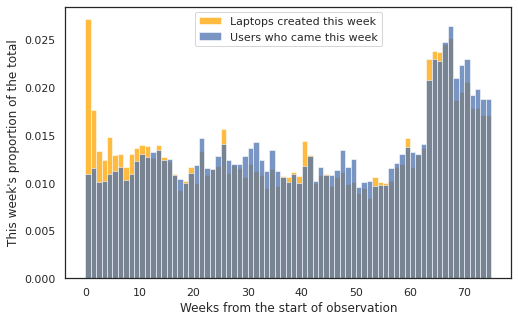

In [5]:
visualize_all_data(data)

<h4>Анализ будем проводить на основании данных, которые собирались примерно 75 недель.</h4>  
  
<p>Мы видим, что первые несколько недель доля новых пользователей превосходит долю созданных ноутбуков, особенно это видно на примере первых двух недель.</p>
<p>Далее картина выравнивается и даже в большинстве недель доля созданных ноутбуков превышает долю новых пользователей, из чего мы можем сделать предположение о том, что ноутбуки создают пользователи, которые уже были на этом ресурсе (растет retention метрика).</p>
<p>Начиная с 65й недели мы наблюдаем резкий рост долей как новых пользователей, так и созданных ноутбуков. Есть повод задуматься о проводимой, в это время, рекламной кампании. Либо сервис был качественно обновлен, что привело к резкому росту новых пользователей.</p>  

<h4>The analysis will be carried out on the basis of data that has been collected for about 75 weeks.</h4>  
  
<p>We see that in the first few weeks the proportion of new users exceeds the proportion of laptops created, especially in the example of the first two weeks.</p>
<p>Further, the indicators are leveled and even in most weeks the proportion of laptops created exceeds the proportion of new users, from which we can make an assumption that laptops are created by users who have already been on this resource (retention metric is growing).</p>
<p>Since the 65th week, we have seen a sharp increase in the proportions of both new users and created laptops. There is a reason to think about the advertising campaign being conducted at this time or the service was qualitatively updated, which led to a sharp increase in new users.</p>

## 1. Выделение когорт по времени присоединения  
## 1. Selection of cohorts by time of joining  

In [6]:
#размер когорты (в этом примере этот параметр будет также использоваться как величина периода для наблюдений за когортой)
#cohort size (and period size)
cohort_size = 14
#интервал времени между когортами для сравнения
#time interval between cohorts
interval_between_cohorts = 60

#найдем для пользоваателей их даты присоединения:
#lets find dates of joining for users
g_data = data.groupby('AuthorUserId')['CreationTimestamp'].first().reset_index()
#колонка delta - день присоединения с начала наблюдения:
#delta column is a namber of day since start of experiment
g_data['delta'] = (g_data['CreationTimestamp'] - data['CreationTimestamp'].min()).apply(lambda x: x.days)


#получим айдишники пользователей присоединившихся в первый период и во второй:
#lets get user ids joining in the first period and in the second one
cohort_1_users = g_data[g_data['delta']<=cohort_size]['AuthorUserId'].unique()
cohort_2_users = g_data.loc[(g_data['delta']>interval_between_cohorts+cohort_size) &
                            (g_data['delta']<=interval_between_cohorts+2*cohort_size)]['AuthorUserId'].unique()

#полные логи событий для каждой из когорт:
#all data for both cohorts
data_c1 = data[data['AuthorUserId'].isin(cohort_1_users)].copy()
data_c2 = data[data['AuthorUserId'].isin(cohort_2_users)].copy()

Визуализируем теперь аналогично время регистрации новых пользователей для выделенных когорт:  
Now we visualize the registration time of new users for the selected cohorts in the same way:  

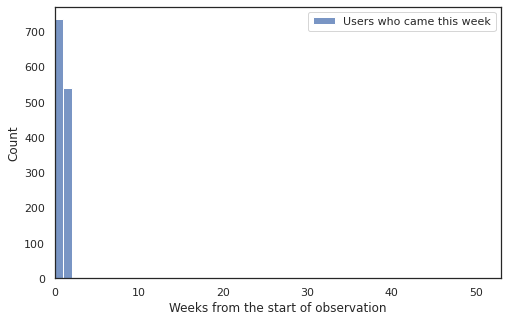

In [7]:
 visualize_users(data_c1)

Визуализируем созданные ноутбуки для каждой из когорт, за всё время наблюдения:  
We visualize the laptops created for each of the cohorts, for the entire time of observation:  

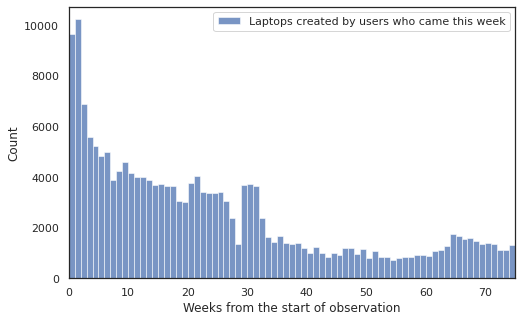

In [8]:
visualize_purchases(data_c1)

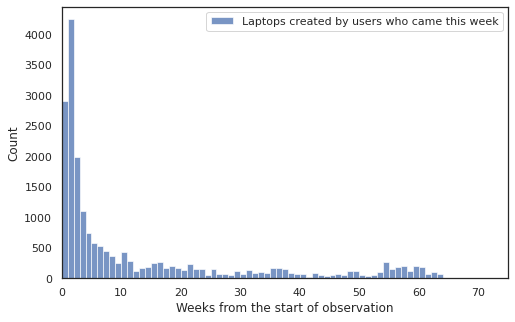

In [9]:
visualize_purchases(data_c2)

Рассмотри разницу между когортами:  
  1. Пользователи пришедшие в сервис в первые 14 дней:  
    Видим, что когорта имеет неплохой retention. Достаточно большая группа пользователей (1500-2000) продолжают пользоваться продуктом спустя 75 недель.
  2. Пользователи, пришедшие в сервис с 75го дня по 88й:  
    Сравнивая с первой когортой, видим большую разницу. Пользователи 2й когорты проявляли активность первые 3 недели, дальше количество возвращающихся пользователей пошло на спад и начиная с 10й недели не превышало 500, а 64я неделя стала последней для пользователей этой когорты.  

Let's consider the difference between cohorts:  
  1. Users who came to the service in the first 14 days:  
    We see that the cohort has a good retention. A fairly large group of users (1500-2000) continue to use the product after 75 weeks.
  2. Users who came to the service from the 75th to the 88th day:  
    Comparing with the first cohort, we see a big difference. Users of the 2nd cohort were active for the first 3 weeks, then the number of returning users began to down and starting from the 10th week, it did not exceed 500, and the 64th week was the last for users of this cohort. 

In [10]:
#здесь delta показывает в какой период времени(14 дней) с начала наблюдения был создан ноутбук для интересующей нас когорты
#here delta shows what period of time(14 days)since the beginning of the observation a laptop was created for the cohort of interest to us
data_c1['delta'] = (data_c1['CreationTimestamp'] - data_c1['CreationTimestamp'].min()).apply(lambda x: np.floor(x.days / cohort_size))
data_c2['delta'] = (data_c2['CreationTimestamp'] - data_c2['CreationTimestamp'].min()).apply(lambda x: np.floor(x.days / cohort_size))

In [11]:
#считаем количество пользователей в каждый из периодов времени для каждой из когорт
#let's calculate the number of users in each of periods for each of cohorts
retention_c1 =  data_c1.groupby('delta')['AuthorUserId'].apply(lambda x: len(set(x)))
retention_c2 =  data_c2.groupby('delta')['AuthorUserId'].apply(lambda x: len(set(x)))

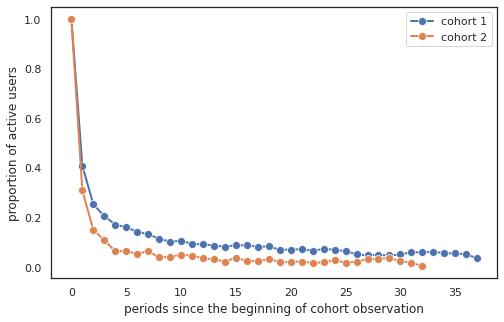

In [12]:
#построим retention график для обеих когорт
#let's build a retention plot for both cohorts
sns.lineplot(x = retention_c1.index, y = retention_c1.values/max(retention_c1.values),
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = retention_c2.index, y = retention_c2.values/max(retention_c2.values),
             lw = 2, marker="o", markersize = 8)

plt.xlabel('periods since the beginning of cohort observation')
plt.ylabel('proportion of active users')

plt.legend(labels=["cohort 1","cohort 2"])
plt.show()


Видим, что пользователи первой когорты более активны на протяжении всего своего жизненного цикла  
We see that users of the first cohort are more active throughout their entire life cycle  



Сравним эти группы по количеству созданных ноутбуков на человека.  
Let's compare these groups by the number of laptops created per person.  

In [13]:
purch_c1 =  data_c1.groupby('delta').apply(lambda x: len(x['Title'])/x['AuthorUserId'].nunique())
purch_c2 =  data_c2.groupby('delta').apply(lambda x: len(x['Title'])/x['AuthorUserId'].nunique())

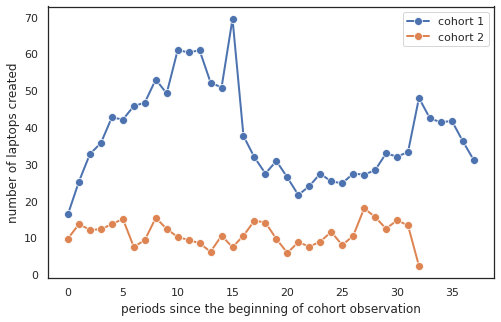

In [14]:
sns.lineplot(x = purch_c1.index, y = purch_c1.values,
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = purch_c2.index, y = purch_c2.values,
             lw = 2, marker="o", markersize = 8)

plt.xlabel('periods since the beginning of cohort observation')
plt.ylabel('number of laptops created')

plt.legend(labels=["cohort 1","cohort 2"])
plt.show()

Видим, что пользователи когорты 1 создавали больше ноутбуков на человека, а значит более активно пользовались сервисом. 
We see that the users of cohort 1 created more laptops per person, which means they used the service more actively.   


Посмотрим количество строк в ноутбуке для каждой из когорт:  
Let's calculate the number of lines in the notebook for each of the cohorts:  

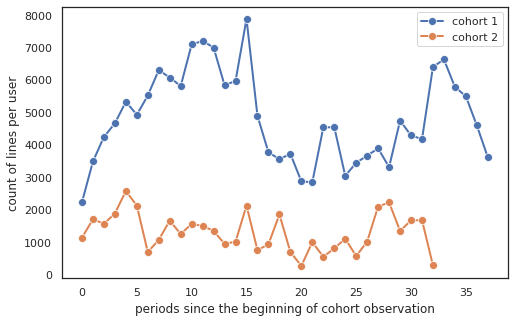

In [15]:
conv_c1 =  data_c1.groupby('delta').apply(lambda x: (x['TotalLines']).sum()/x['AuthorUserId'].nunique())
conv_c2 =  data_c2.groupby('delta').apply(lambda x: (x['TotalLines']).sum()/x['AuthorUserId'].nunique())

sns.lineplot(x = conv_c1.index, y = conv_c1.values,
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = conv_c2.index, y = conv_c2.values,
             lw = 2, marker="o", markersize = 8)

plt.xlabel('periods since the beginning of cohort observation')
plt.ylabel('count of lines per user')

plt.legend(labels=["cohort 1","cohort 2"])
plt.show()

Видно, что пользователи когорты 1 писали больше строк в ноутбуках  
We see that the users of cohort 1 wrote more lines in laptops  

## 2. Выделение сегментов внутри когорт  
## 2. Highlighting of segments within cohorts


Важно  помнить, что в общем случае, когорты можно выделять произвольным образом в зависимости от анализа. 

В примерее выше мы сделали  выделение когорт на основе acquisition time.

Давайте рассмотрим теперь другой способ выделения когорт. Для этого опять изолируем пользователей пришедших за определенный  промежуток времени (например тоже за первые две недели наблюдения) и разобьем их на две когорты - пользователи писавшие на самом редкоиспользуемом языке программирования(ЯП) (1) и на самом часто используемом (9):

In [16]:
#здесь видно количество раз, когда был использован каждый из ЯП
#here you can see the number of times each of the programming languages has been used
data.groupby('ScriptLanguageId').count()['Id']

ScriptLanguageId
1       2161
2      12049
5       5963
8     444460
9     372508
12     14433
13     16204
14     11901
15      2380
16      2678
Name: Id, dtype: int64

In [17]:
#найдем для пользоваателей их даты присоединения:
#let's find date of joining for each user
g_data = data.groupby('AuthorUserId')['CreationTimestamp'].first().to_frame()
#колонка delta - день присоединения с начала наблюдения:
#delta column - the day of joining from the begining of observation 
g_data['delta'] = (g_data['CreationTimestamp'] - data['CreationTimestamp'].min()).apply(lambda x: x.days)


In [18]:
#перенесем день присоединения с начала наблюдения в датафрейм data
#move the acquisition day to the data dataframe
data['acquisition_day'] = data['AuthorUserId'].map(g_data['delta'].to_dict())

In [19]:
#найдем пользователей для каждого из сегментов
#let's find users for each segmets
segment_1_users = data.loc[(data['acquisition_day']<=cohort_size) & (data['ScriptLanguageId']==1)]['AuthorUserId'].unique()
segment_2_users = data.loc[(data['acquisition_day']<=cohort_size) & (data['ScriptLanguageId']==9)]['AuthorUserId'].unique()

#полные логи событий для каждой из когорт:
#all data for each segments:
data_s1 = data[data['AuthorUserId'].isin(segment_1_users)].copy()
data_s2 = data[data['AuthorUserId'].isin(segment_2_users)].copy()

Далее проведем сравнителньый анализ аналогичный проделанному выше по выделенным сегментам:  
Next, we will conduct a comparative analysis similar to the one done above for the selected segments:

In [20]:
data_s1['delta'] = (data_s1['CreationTimestamp'] - data_s1['CreationTimestamp'].min()).apply(lambda x: np.floor(x.days / cohort_size))
data_s2['delta'] = (data_s2['CreationTimestamp'] - data_s2['CreationTimestamp'].min()).apply(lambda x: np.floor(x.days / cohort_size))

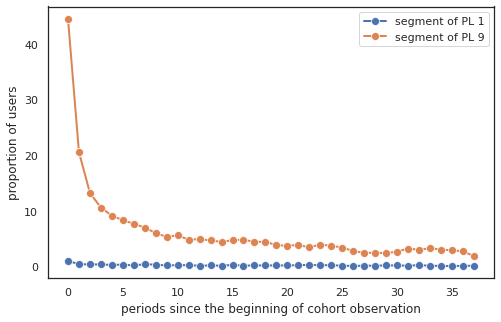

In [21]:
#считаем количество пользователей в каждый из периодов времени для каждого из сегментов
#let's calculate the number of users in each of periods for each of segments
retention_s1 =  data_s1.groupby('delta')['AuthorUserId'].apply(lambda x: len(set(x)))
retention_s2 =  data_s2.groupby('delta')['AuthorUserId'].apply(lambda x: len(set(x)))

sns.lineplot(x = retention_s1.index, y = retention_s1.values/max(retention_s1.values), lw = 2, marker="o", markersize = 8)
sns.lineplot(x = retention_s2.index, y = retention_s2.values/max(retention_s1.values), lw = 2, marker="o", markersize = 8)

plt.xlabel('periods since the beginning of cohort observation')
plt.ylabel('proportion of users')

plt.legend(labels=["segment of PL 1","segment of PL 9"])
plt.show()


Из графика видно, что изначально пользователей использующих ЯП 9 гораздо больше, но со временем их количество приближается к количеству пользователей, которые используют ЯП 1.  
The plot shows that initially there are much more users using programming language 9, but over time their number approaches the number of users who use programming language 1

Теперь сравним количество строк, написанных на данных языках:  
Now let's compare the number of lines written in these languages:  


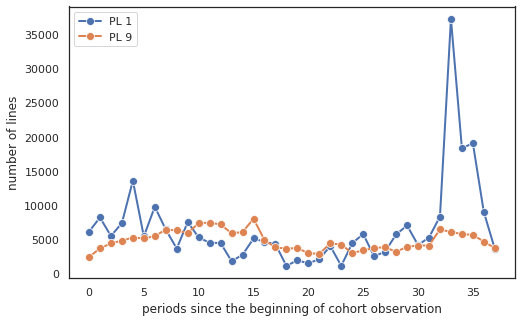

In [22]:
conv_s1 =  data_s1.groupby('delta').apply(lambda x: (x['TotalLines']).sum()/x['AuthorUserId'].nunique())
conv_s2 =  data_s2.groupby('delta').apply(lambda x: (x['TotalLines']).sum()/x['AuthorUserId'].nunique())

sns.lineplot(x = conv_s1.index, y = conv_s1.values, lw = 2, marker="o", markersize = 8)
sns.lineplot(x = conv_s2.index, y = conv_s2.values, lw = 2, marker="o", markersize = 8)

plt.xlabel('periods since the beginning of cohort observation')
plt.ylabel('number of lines')

plt.legend(labels=["PL 1","PL 9"])
plt.show()

Видим, что несмотря на то, что ЯП 9 намного популярнее, количество строк написанных на ЯП 1 переодически превышает количество строк написанных на ЯП 9. Особенно интересен отрезок 30-35, где на ЯП 1 было написано порядка 35000 строк кода.  
We see that despite the fact that programming language 9 is much more popular, the number of lines written in programming language 1 periodically exceeds the number of lines written in programming language 9. The interval 30-35 is especially interesting, where about 35,000 lines of code were written in programming language 1.  


## 3.  Когортная матрица retention для многих групп:
## 3.  Retention cohort matrix for many groups:  



In [23]:
#за интервал возьмем 1 месяц(30 дней):
#let's take 1 month(30 days) for interval
cohort_size = 30

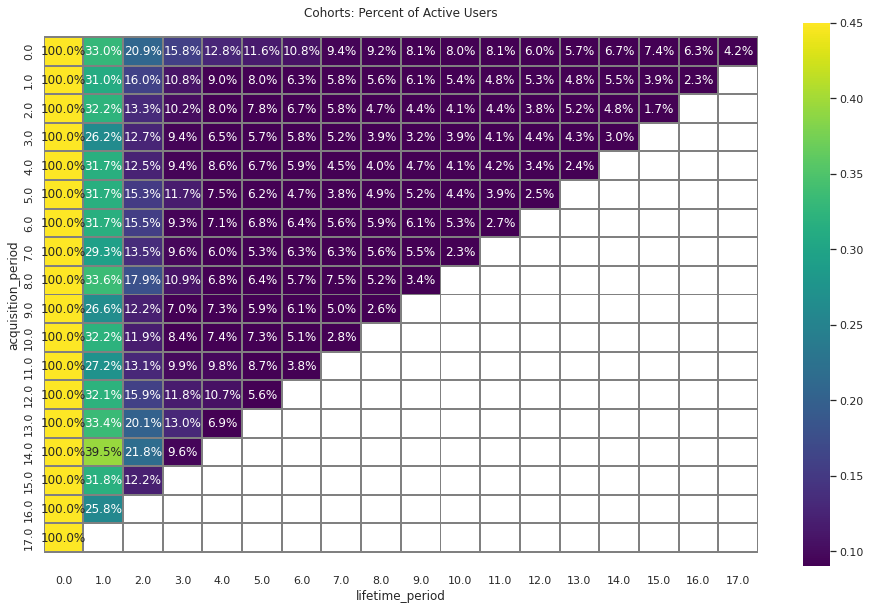

In [24]:
cohorts = data.groupby(['acquisition_period','lifetime_period']).agg({'AuthorUserId':'nunique'}).reset_index()

inital_users_count = cohorts[cohorts['lifetime_period'] == 0][['acquisition_period','AuthorUserId']]
inital_users_count = inital_users_count.rename(columns={'AuthorUserId':'cohort_users'})


cohorts = cohorts.merge(inital_users_count,on='acquisition_period')
cohorts['metric'] = cohorts['AuthorUserId']/cohorts['cohort_users']

cohort_metric_pivot = cohorts.pivot_table(index='acquisition_period',
                                      columns='lifetime_period'
                                      ,values='metric',
                                      aggfunc='sum')

sns.set(style='white', context='notebook', rc={'figure.figsize':(16,10)})

plt.title('Cohorts: Percent of Active Users')
sns.heatmap(cohort_metric_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='viridis',
            vmin=0.09, vmax=0.45,)

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

plt.show();

Видим достаточно равномерно убывающую матрицу. Можно выделить первую кагорту, как самую активную и достаточно высокий показатель во втором месяце 14й когорты.  
We see a fairly uniformly decreasing matrix. The first cohort can be distinguished as the most active and rather high indicator in the second month of the 14th cohort.  

# 4. Выделение сегментов в когортной матрице  
# 4. Highlighting segments in a cohort matrix  

Когортная матрица для пользователей, использующих язык программирования 9:  
Cohort matrix for users using programming language 9:  

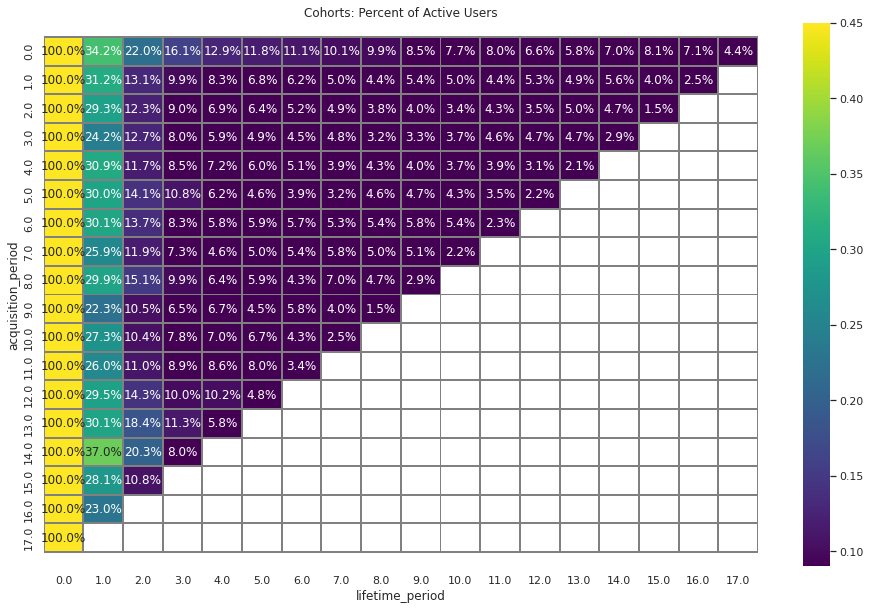

In [25]:
cohorts = data[data['ScriptLanguageId']==9].groupby(['acquisition_period','lifetime_period']).agg({'AuthorUserId':'nunique'}).reset_index()

inital_users_count = cohorts[cohorts['lifetime_period'] == 0][['acquisition_period','AuthorUserId']]
inital_users_count = inital_users_count.rename(columns={'AuthorUserId':'cohort_users'})


cohorts = cohorts.merge(inital_users_count,on='acquisition_period')
cohorts['metric'] = cohorts['AuthorUserId']/cohorts['cohort_users']

cohort_metric_pivot = cohorts.pivot_table(index='acquisition_period',
                                      columns='lifetime_period'
                                      ,values='metric',
                                      aggfunc='sum')

sns.set(style='white', context='notebook', rc={'figure.figsize':(16,10)})

plt.title('Cohorts: Percent of Active Users')
sns.heatmap(cohort_metric_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='viridis',
            vmin=0.09, vmax=0.45,)

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

plt.show();

Когортная матрица для пользователей, использующих язык программирования 1:  
Cohort matrix for users using programming language 1:  

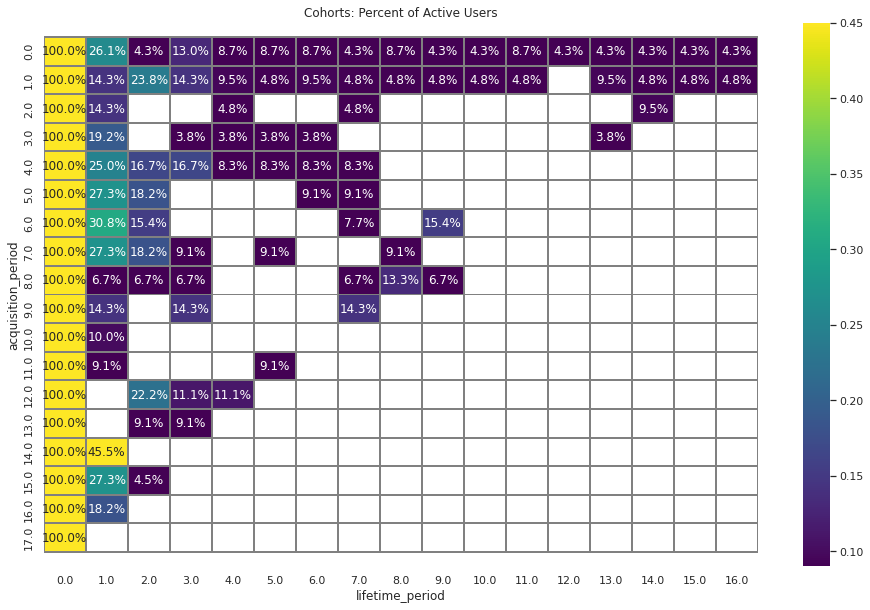

In [26]:
cohorts = data[data['ScriptLanguageId']==1].groupby(['acquisition_period','lifetime_period']).agg({'AuthorUserId':'nunique'}).reset_index()

inital_users_count = cohorts[cohorts['lifetime_period'] == 0][['acquisition_period','AuthorUserId']]
inital_users_count = inital_users_count.rename(columns={'AuthorUserId':'cohort_users'})


cohorts = cohorts.merge(inital_users_count,on='acquisition_period')
cohorts['metric'] = cohorts['AuthorUserId']/cohorts['cohort_users']

cohort_metric_pivot = cohorts.pivot_table(index='acquisition_period',
                                      columns='lifetime_period'
                                      ,values='metric',
                                      aggfunc='sum')

sns.set(style='white', context='notebook', rc={'figure.figsize':(16,10)})

plt.title('Cohorts: Percent of Active Users')
sns.heatmap(cohort_metric_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='viridis',
            vmin=0.09, vmax=0.45,)

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

plt.show();

Анализируя две эти матрицы можно отметить, что матрица ЯП 9 ведет себя примерно также, как и матрица общей активности пользователей, т.е. ЯП 9 пользуется популярностью у большинства пользователей и интерес к нему убывает с течением времени (вероятно с уходом пользователей из сервиса). А ЯП 1 используют время от времени (вероятно для каких-либо специфических проектов).  
Analyzing these two matrices, it can be noted that the matrix of programming language 9 behaves approximately the same as the matrix of general user activity, i.e. programming language 9 is popular with most users and interest in it decreases over time (probably with the departure of users from the service). And programming language 1 is used from time to time (probably for some specific projects).  